In [1]:
import segmentation_models as sm
from keras.utils import to_categorical
from preparation import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from simple_multi_unet_model import multi_unet_model, jacard_coef
import keras
import pickle
from keras.models import load_model
from patchify import patchify, unpatchify
from smooth_tiled_predictions import predict_img_with_smooth_windowing

Segmentation Models: using `keras` framework.


In [2]:
weights = [0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Load the trained model

In [3]:
# import Trained Model
'''with keras.utils.custom_object_scope({
    'dice_loss_plus_1focal_loss': total_loss,
    'jacard_coef': jacard_coef
}):
    model = load_model("models/trained_satellite_standard_unet_100epochs_v1.hdf5")'''

model = load_model("models/trained_satellite_standard_unet_10epochs_v5.hdf5", compile=False)

In [4]:
# size of patches
patch_size = 256

# Set the image link

In [29]:
# Paste the URL link of your image here

url_img_link = 'https://media.licdn.com/dms/image/D5622AQHlUirpkNS5aw/feedshare-shrink_800/0/1682643405952?e=1686787200&v=beta&t=31OiUuMdno3jkD2wF0T3wavXD2SRkeCsB-d8wJm5ebE'

# load the image

In [30]:
# download a test image from any image link
#test_image = load_image_from_url(url_img_link)
test_image = load_image_from_url(url_img_link)
test_image.save('input.png')

In [39]:
img = cv2.imread("input.jpg", 1)

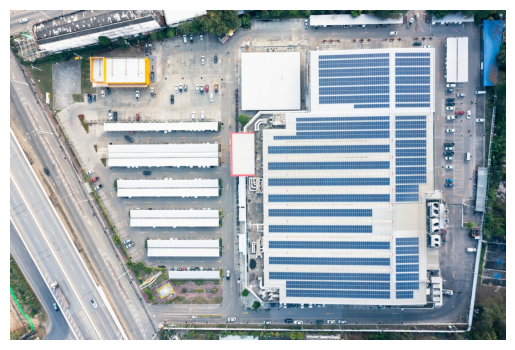

In [40]:
plot_image(img)

In [41]:
type(img)

numpy.ndarray

In [42]:
img.size

3147540

# Predict patch by patch with no smooth blending

In [43]:
# Number of classes
n_classes = 2

In [44]:
SIZE_X = (img.shape[1] // patch_size) * patch_size  # The nearest size divisible by our patch size
SIZE_Y = (img.shape[0] // patch_size) * patch_size  # The nearest size divisible by our patch size

In [45]:
large_img = Image.fromarray(img)
large_img = large_img.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from the top left corner

In [46]:
large_img = np.array(large_img)

In [47]:
patches_img = patchify(large_img, (patch_size, patch_size, 3),
                       step=patch_size)  # Step=256 for 256 patches means no overlap
patches_img = patches_img[:, :, 0, :, :, :]

In [48]:
patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]

        # Use minmaxscaler instead of just dividing by 255.
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(
            single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :, :]

        patched_prediction.append(pred)

1/1 [==============================] - 0s 77ms/step


In [49]:
patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1],
                                                     patches_img.shape[2], patches_img.shape[3]])

In [50]:
unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

(-0.5, 1023.5, 767.5, -0.5)

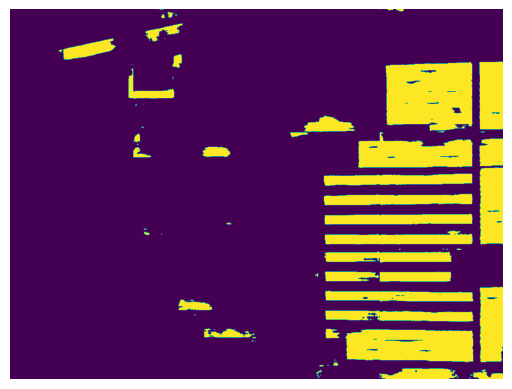

In [51]:
plt.imshow(unpatched_prediction)
plt.axis('off')

# Predict using smooth blending

In [52]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

In [53]:
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

final_prediction = np.argmax(predictions_smooth, axis=2)

  0%|          | 0/8 [00:00<?, ?it/s]

3/3 [==============================] - 3s 767ms/step


 12%|█▎        | 1/8 [00:04<00:30,  4.33s/it]

3/3 [==============================] - 3s 738ms/step


 25%|██▌       | 2/8 [00:07<00:23,  3.89s/it]

3/3 [==============================] - 3s 718ms/step


 38%|███▊      | 3/8 [00:11<00:18,  3.71s/it]

3/3 [==============================] - 3s 714ms/step


 50%|█████     | 4/8 [00:14<00:14,  3.63s/it]

3/3 [==============================] - 3s 713ms/step


 62%|██████▎   | 5/8 [00:18<00:10,  3.57s/it]

3/3 [==============================] - 3s 723ms/step


 75%|███████▌  | 6/8 [00:21<00:07,  3.56s/it]

3/3 [==============================] - 3s 717ms/step


 88%|████████▊ | 7/8 [00:25<00:03,  3.54s/it]

3/3 [==============================] - 3s 721ms/step


100%|██████████| 8/8 [00:28<00:00,  3.62s/it]


# Convert labeled images back to original RGB colored masks

In [54]:
def label_to_rgb(predicted_image):
    solar_panels = '#d3d3d3'.lstrip('#')
    solar_panels = np.array(tuple(int(solar_panels[i:i + 2], 16) for i in (0, 2, 4)))

    land = '#000000'.lstrip('#')
    land = np.array(tuple(int(land[i:i + 2], 16) for i in (0, 2, 4)))

    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    segmented_img[(predicted_image == 1)] = solar_panels
    segmented_img[(predicted_image == 0)] = land

    segmented_img = segmented_img.astype(np.uint8)
    return (segmented_img)

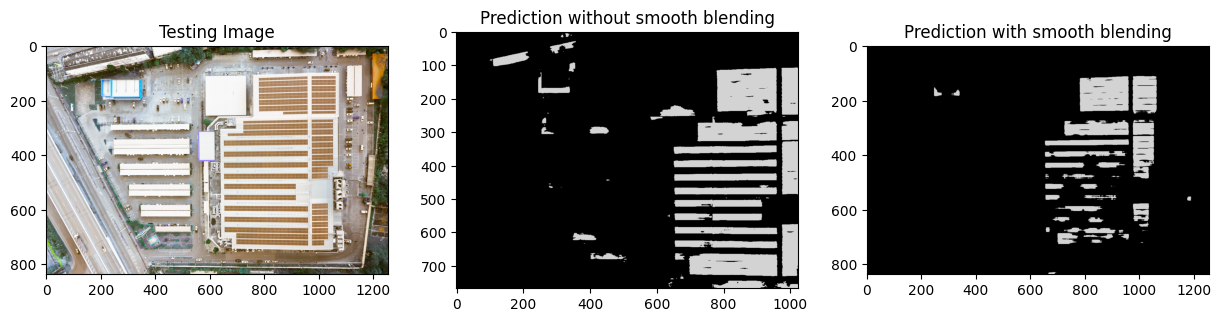

In [55]:
# Plot and save results
prediction_with_smooth_blending = label_to_rgb(final_prediction)
prediction_without_smooth_blending = label_to_rgb(unpatched_prediction)

plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(132)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(133)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()